In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(6)*train_x + torch.randn(train_x.size()) * float(0.2)


# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[ -7.8100, -12.2900],
        [ -7.3919, -11.2566],
        [ -6.5166, -11.0004],
        [ -5.2783, -10.8051],
        [ -4.5696,  -9.9075],
        [ -4.0675,  -9.6116],
        [ -3.5428,  -9.1930],
        [ -2.5036,  -8.3545],
        [ -2.4907,  -7.9029],
        [ -2.1055,  -7.8430],
        [ -1.6026,  -6.8198],
        [ -1.1930,  -6.7310],
        [ -1.0678,  -6.0979],
        [ -1.0343,  -5.6321],
        [ -0.7426,  -4.7207],
        [ -0.4454,  -4.8080],
        [ -0.

In [4]:

len(train_y.shape)

2

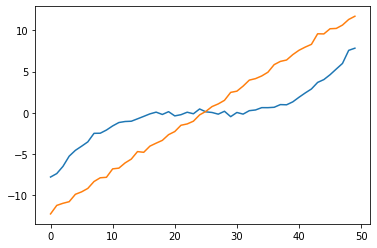

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, kernel2], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  0.0000e+00,  9.9667e-01,  ..., -1.8160e-03,
          3.3546e-04, -1.3419e-03],
        [ 0.0000e+00,  1.0000e+00,  8.1361e-02,  ..., -6.6522e-03,
          1.3419e-03, -5.0319e-03],
        [ 9.9667e-01,  8.1361e-02,  1.0000e+00,  ..., -2.4403e-03,
          4.6345e-04, -1.8160e-03],
        ...,
        [-1.8160e-03, -6.6522e-03, -2.4403e-03,  ...,  1.0000e+00,
          8.1361e-02,  9.9003e-01],
        [ 3.3546e-04,  1.3419e-03,  4.6345e-04,  ...,  8.1361e-02,
          1.0000e+00,  0.0000e+00],
        [-1.3419e-03, -5.0319e-03, -1.8160e-03,  ...,  9.9003e-01,
          0.0000e+00,  1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2969e+01,  0.0000e+00],
        [ 2.8123e+01,  0.0000e+00],
        [ 1.8031e+01,  0.0000e+00],
        [ 1.1853e+01,  0.0000e+00],
        [ 6.0685e+00,  0.0000e+00],
        [ 2.2329e+00,  0.0000e+00],
        [ 5.8205e-01,  0.0000e+00],
        [ 1.1878e-01,  0.0000e+00],
        [ 2.0032e-02,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:669: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052e+00,  0.0000e+00,  1.1007e+00,  ..., -4.4797e-04,
          6.3073e-05, -3.0815e-04],
        [ 0.0000e+00,  1.3499e+00,  1.0974e-01,  ..., -2.0296e-03,
          3.0815e-04, -1.4285e-03],
        [ 1.1007e+00,  1.0974e-01,  1.1052e+00,  ..., -6.4567e-04,
          9.3601e-05, -4.4797e-04],
        ...,
        [-4.4797e-04, -2.0296e-03, -6.4567e-04,  ...,  1.3499e+00,
          1.0974e-01,  1.3334e+00],
        [ 6.3073e-05,  3.0815e-04,  9.3601e-05,  ...,  1.0974e-01,
          1.1052e+00,  0.0000e+00],
        [-3.0815e-04, -1.4285e-03, -4.4797e-04,  ...,  1.3334e+00,
          0.0000e+00,  1.3499e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6211e+01,  0.0000e+00],
        [ 3.3365e+01,  0.0000e+00],
        [ 2.2125e+01,  0.0000e+00],
        [ 1.5734e+01,  0.0000e+00],
        [ 9.2781e+00,  0.0000e+00],
        [ 4.2461e+00,  0.0000e+00],
        [ 1.3647e+00,  0.0000e+00],
        [ 3.4174e-01,  0.0000e+00],
        [ 7.0430e-02,

tensor([[ 1.3461e+00,  0.0000e+00,  1.3381e+00,  ..., -9.2602e-06,
          7.3181e-07, -5.2782e-06],
        [ 0.0000e+00,  2.4273e+00,  1.9696e-01,  ..., -6.3063e-05,
          5.2782e-06, -3.6749e-05],
        [ 1.3381e+00,  1.9696e-01,  1.3461e+00,  ..., -1.6045e-05,
          1.3107e-06, -9.2602e-06],
        ...,
        [-9.2602e-06, -6.3063e-05, -1.6045e-05,  ...,  2.4273e+00,
          1.9696e-01,  2.3837e+00],
        [ 7.3181e-07,  5.2782e-06,  1.3107e-06,  ...,  1.9696e-01,
          1.3461e+00,  0.0000e+00],
        [-5.2782e-06, -3.6749e-05, -9.2602e-06,  ...,  2.3837e+00,
          0.0000e+00,  2.4273e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5607e+01,  0.0000e+00],
        [ 4.6918e+01,  0.0000e+00],
        [ 3.2978e+01,  0.0000e+00],
        [ 2.5668e+01,  0.0000e+00],
        [ 1.7092e+01,  0.0000e+00],
        [ 1.1767e+01,  0.0000e+00],
        [ 5.6763e+00,  0.0000e+00],
        [ 2.1141e+00,  0.0000e+00],
        [ 6.3857e-01,

tensor([[ 1.6282e+00,  0.0000e+00,  1.6144e+00,  ..., -4.5281e-08,
          1.9637e-09, -2.0163e-08],
        [ 0.0000e+00,  4.1796e+00,  3.3829e-01,  ..., -4.4390e-07,
          2.0163e-08, -2.0200e-07],
        [ 1.6144e+00,  3.3829e-01,  1.6282e+00,  ..., -9.9921e-08,
          4.5018e-09, -4.5281e-08],
        ...,
        [-4.5281e-08, -4.4390e-07, -9.9921e-08,  ...,  4.1796e+00,
          3.3829e-01,  4.0732e+00],
        [ 1.9637e-09,  2.0163e-08,  4.5018e-09,  ...,  3.3829e-01,
          1.6282e+00,  0.0000e+00],
        [-2.0163e-08, -2.0200e-07, -4.5281e-08,  ...,  4.0732e+00,
          0.0000e+00,  4.1796e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.4170e+01,  0.0000e+00],
        [ 6.2158e+01,  0.0000e+00],
        [ 4.6075e+01,  0.0000e+00],
        [ 4.1818e+01,  0.0000e+00],
        [ 2.6295e+01,  0.0000e+00],
        [ 2.1889e+01,  0.0000e+00],
        [ 1.4602e+01,  0.0000e+00],
        [ 8.1642e+00,  0.0000e+00],
        [ 3.4515e+00,

tensor([[ 1.9508e+00,  0.0000e+00,  1.9284e+00,  ..., -6.9582e-11,
          1.6634e-12, -2.3113e-11],
        [ 0.0000e+00,  6.7768e+00,  5.4684e-01,  ..., -9.2936e-10,
          2.3113e-11, -3.1538e-10],
        [ 1.9284e+00,  5.4684e-01,  1.9508e+00,  ..., -2.0459e-10,
          5.1119e-12, -6.9582e-11],
        ...,
        [-6.9582e-11, -9.2936e-10, -2.0459e-10,  ...,  6.7768e+00,
          5.4684e-01,  6.5438e+00],
        [ 1.6634e-12,  2.3113e-11,  5.1119e-12,  ...,  5.4684e-01,
          1.9508e+00,  0.0000e+00],
        [-2.3113e-11, -3.1538e-10, -6.9582e-11,  ...,  6.5438e+00,
          0.0000e+00,  6.7768e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.5083e+01,  0.0000e+00],
        [ 8.6283e+01,  0.0000e+00],
        [ 6.0696e+01,  0.0000e+00],
        [ 6.5524e+01,  0.0000e+00],
        [ 4.2739e+01,  0.0000e+00],
        [ 3.3999e+01,  0.0000e+00],
        [ 2.2843e+01,  0.0000e+00],
        [ 1.9313e+01,  0.0000e+00],
        [ 1.1189e+01,

tensor([[ 2.3117e+00,  0.0000e+00,  2.2779e+00,  ..., -6.9849e-14,
          9.6295e-16, -1.7051e-14],
        [ 0.0000e+00,  1.0234e+01,  8.2317e-01,  ..., -1.1938e-12,
          1.7051e-14, -2.9767e-13],
        [ 2.2779e+00,  8.2317e-01,  2.3117e+00,  ..., -2.7770e-13,
          4.0269e-15, -6.9849e-14],
        ...,
        [-6.9849e-14, -1.1938e-12, -2.7770e-13,  ...,  1.0234e+01,
          8.2317e-01,  9.7863e+00],
        [ 9.6295e-16,  1.7051e-14,  4.0269e-15,  ...,  8.2317e-01,
          2.3117e+00,  0.0000e+00],
        [-1.7051e-14, -2.9767e-13, -6.9849e-14,  ...,  9.7863e+00,
          0.0000e+00,  1.0234e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1402e+02,  0.0000e+00],
        [ 1.1184e+02,  0.0000e+00],
        [ 9.0281e+01,  0.0000e+00],
        [ 8.4636e+01,  0.0000e+00],
        [ 5.9703e+01,  0.0000e+00],
        [ 5.5129e+01,  0.0000e+00],
        [ 3.3775e+01,  0.0000e+00],
        [ 2.9799e+01,  0.0000e+00],
        [ 2.1189e+01,

tensor([[ 2.7073e+00,  0.0000e+00,  2.6599e+00,  ..., -1.2349e-16,
          1.0743e-18, -2.2759e-17],
        [ 0.0000e+00,  1.4339e+01,  1.1500e+00,  ..., -2.5312e-15,
          2.2759e-17, -4.7647e-16],
        [ 2.6599e+00,  1.1500e+00,  2.7073e+00,  ..., -6.4648e-16,
          5.9502e-18, -1.2349e-16],
        ...,
        [-1.2349e-16, -2.5312e-15, -6.4648e-16,  ...,  1.4339e+01,
          1.1500e+00,  1.3591e+01],
        [ 1.0743e-18,  2.2759e-17,  5.9502e-18,  ...,  1.1500e+00,
          2.7073e+00,  0.0000e+00],
        [-2.2759e-17, -4.7647e-16, -1.2349e-16,  ...,  1.3591e+01,
          0.0000e+00,  1.4339e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.4366e+02,  0.0000e+00],
        [ 1.4366e+02,  0.0000e+00],
        [ 1.1394e+02,  0.0000e+00],
        [ 1.1581e+02,  0.0000e+00],
        [ 7.5198e+01,  0.0000e+00],
        [ 8.2297e+01,  0.0000e+00],
        [ 5.2330e+01,  0.0000e+00],
        [ 4.1280e+01,  0.0000e+00],
        [ 2.7820e+01,

tensor([[ 3.1324e+00,  0.0000e+00,  3.0709e+00,  ..., -1.0567e-18,
          6.6227e-21, -1.5764e-19],
        [ 0.0000e+00,  1.8640e+01,  1.4917e+00,  ..., -2.4370e-17,
          1.5764e-19, -3.7129e-18],
        [ 3.0709e+00,  1.4917e+00,  3.1324e+00,  ..., -6.8056e-18,
          4.5321e-20, -1.0567e-18],
        ...,
        [-1.0567e-18, -2.4370e-17, -6.8056e-18,  ...,  1.8640e+01,
          1.4917e+00,  1.7549e+01],
        [ 6.6227e-21,  1.5764e-19,  4.5321e-20,  ...,  1.4917e+00,
          3.1324e+00,  0.0000e+00],
        [-1.5764e-19, -3.7129e-18, -1.0567e-18,  ...,  1.7549e+01,
          0.0000e+00,  1.8640e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.7448e+02,  0.0000e+00],
        [ 1.7640e+02,  0.0000e+00],
        [ 1.4660e+02,  0.0000e+00],
        [ 1.3913e+02,  0.0000e+00],
        [ 1.0796e+02,  0.0000e+00],
        [ 9.4584e+01,  0.0000e+00],
        [ 6.9411e+01,  0.0000e+00],
        [ 5.7113e+01,  0.0000e+00],
        [ 3.5505e+01,

tensor([[ 3.5809e+00,  0.0000e+00,  3.5065e+00,  ..., -8.6116e-20,
          4.5487e-22, -1.1467e-20],
        [ 0.0000e+00,  2.2567e+01,  1.8040e+00,  ..., -2.1046e-18,
          1.1467e-20, -2.8620e-19],
        [ 3.5065e+00,  1.8040e+00,  3.5809e+00,  ..., -6.1987e-19,
          3.4873e-21, -8.6116e-20],
        ...,
        [-8.6116e-20, -2.1046e-18, -6.1987e-19,  ...,  2.2567e+01,
          1.8040e+00,  2.1170e+01],
        [ 4.5487e-22,  1.1467e-20,  3.4873e-21,  ...,  1.8040e+00,
          3.5809e+00,  0.0000e+00],
        [-1.1467e-20, -2.8620e-19, -8.6116e-20,  ...,  2.1170e+01,
          0.0000e+00,  2.2567e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.0465e+02,  0.0000e+00],
        [ 2.0740e+02,  0.0000e+00],
        [ 1.7408e+02,  0.0000e+00],
        [ 1.6457e+02,  0.0000e+00],
        [ 1.2934e+02,  0.0000e+00],
        [ 1.1490e+02,  0.0000e+00],
        [ 8.2704e+01,  0.0000e+00],
        [ 7.2450e+01,  0.0000e+00],
        [ 4.4445e+01,

tensor([[ 4.0463e+00,  0.0000e+00,  3.9618e+00,  ..., -7.7162e-20,
          4.0157e-22, -1.0173e-20],
        [ 0.0000e+00,  2.5625e+01,  2.0482e+00,  ..., -1.8951e-18,
          1.0173e-20, -2.5515e-19],
        [ 3.9618e+00,  2.0482e+00,  4.0463e+00,  ..., -5.6087e-19,
          3.1095e-21, -7.7162e-20],
        ...,
        [-7.7162e-20, -1.8951e-18, -5.6087e-19,  ...,  2.5625e+01,
          2.0482e+00,  2.4032e+01],
        [ 4.0157e-22,  1.0173e-20,  3.1095e-21,  ...,  2.0482e+00,
          4.0463e+00,  0.0000e+00],
        [-1.0173e-20, -2.5515e-19, -7.7162e-20,  ...,  2.4032e+01,
          0.0000e+00,  2.5625e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.3177e+02,  0.0000e+00],
        [ 2.3490e+02,  0.0000e+00],
        [ 1.9731e+02,  0.0000e+00],
        [ 1.8656e+02,  0.0000e+00],
        [ 1.4666e+02,  0.0000e+00],
        [ 1.3056e+02,  0.0000e+00],
        [ 9.3723e+01,  0.0000e+00],
        [ 8.2609e+01,  0.0000e+00],
        [ 5.0676e+01,

tensor([[ 4.5223e+00,  0.0000e+00,  4.4315e+00,  ..., -5.5067e-19,
          3.2294e-21, -7.8622e-20],
        [ 0.0000e+00,  2.7524e+01,  2.2018e+00,  ..., -1.2992e-17,
          7.8622e-20, -1.8944e-18],
        [ 4.4315e+00,  2.2018e+00,  4.5223e+00,  ..., -3.7020e-18,
          2.3090e-20, -5.5067e-19],
        ...,
        [-5.5067e-19, -1.2992e-17, -3.7020e-18,  ...,  2.7524e+01,
          2.2018e+00,  2.5878e+01],
        [ 3.2294e-21,  7.8622e-20,  2.3090e-20,  ...,  2.2018e+00,
          4.5223e+00,  0.0000e+00],
        [-7.8622e-20, -1.8944e-18, -5.5067e-19,  ...,  2.5878e+01,
          0.0000e+00,  2.7524e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.5441e+02,  0.0000e+00],
        [ 2.5752e+02,  0.0000e+00],
        [ 2.1495e+02,  0.0000e+00],
        [ 2.0343e+02,  0.0000e+00],
        [ 1.5896e+02,  0.0000e+00],
        [ 1.3966e+02,  0.0000e+00],
        [ 1.0204e+02,  0.0000e+00],
        [ 8.5840e+01,  0.0000e+00],
        [ 5.2924e+01,

tensor([[ 5.0032e+00,  0.0000e+00,  4.9100e+00,  ..., -1.7282e-17,
          1.2630e-19, -2.8498e-18],
        [ 0.0000e+00,  2.8221e+01,  2.2609e+00,  ..., -3.7757e-16,
          2.8498e-18, -6.3587e-17],
        [ 4.9100e+00,  2.2609e+00,  5.0032e+00,  ..., -1.0090e-16,
          7.8193e-19, -1.7282e-17],
        ...,
        [-1.7282e-17, -3.7757e-16, -1.0090e-16,  ...,  2.8221e+01,
          2.2609e+00,  2.6655e+01],
        [ 1.2630e-19,  2.8498e-18,  7.8193e-19,  ...,  2.2609e+00,
          5.0032e+00,  0.0000e+00],
        [-2.8498e-18, -6.3587e-17, -1.7282e-17,  ...,  2.6655e+01,
          0.0000e+00,  2.8221e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.7244e+02,  0.0000e+00],
        [ 2.7426e+02,  0.0000e+00],
        [ 2.1637e+02,  0.0000e+00],
        [ 2.2511e+02,  0.0000e+00],
        [ 1.6352e+02,  0.0000e+00],
        [ 1.4443e+02,  0.0000e+00],
        [ 1.0504e+02,  0.0000e+00],
        [ 8.3415e+01,  0.0000e+00],
        [ 5.3603e+01,

tensor([[ 5.4847e+00,  0.0000e+00,  5.3926e+00,  ..., -1.2345e-15,
          1.1989e-17, -2.4376e-16],
        [ 0.0000e+00,  2.7879e+01,  2.2376e+00,  ..., -2.4273e-14,
          2.4376e-16, -4.8953e-15],
        [ 5.3926e+00,  2.2376e+00,  5.4847e+00,  ..., -6.0410e-15,
          6.1981e-17, -1.2345e-15],
        ...,
        [-1.2345e-15, -2.4273e-14, -6.0410e-15,  ...,  2.7879e+01,
          2.2376e+00,  2.6483e+01],
        [ 1.1989e-17,  2.4376e-16,  6.1981e-17,  ...,  2.2376e+00,
          5.4847e+00,  0.0000e+00],
        [-2.4376e-16, -4.8953e-15, -1.2345e-15,  ...,  2.6483e+01,
          0.0000e+00,  2.7879e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.8627e+02,  0.0000e+00],
        [ 2.8487e+02,  0.0000e+00],
        [ 2.2706e+02,  0.0000e+00],
        [ 2.2661e+02,  0.0000e+00],
        [ 1.4947e+02,  0.0000e+00],
        [ 1.5829e+02,  0.0000e+00],
        [ 9.9631e+01,  0.0000e+00],
        [ 7.9747e+01,  0.0000e+00],
        [ 5.5175e+01,

tensor([[ 5.9643e+00,  0.0000e+00,  5.8758e+00,  ..., -1.1295e-13,
          1.5046e-15, -2.7019e-14],
        [ 0.0000e+00,  2.6777e+01,  2.1534e+00,  ..., -1.9581e-12,
          2.7019e-14, -4.7846e-13],
        [ 5.8758e+00,  2.1534e+00,  5.9643e+00,  ..., -4.5804e-13,
          6.4206e-15, -1.1295e-13],
        ...,
        [-1.1295e-13, -1.9581e-12, -4.5804e-13,  ...,  2.6777e+01,
          2.1534e+00,  2.5590e+01],
        [ 1.5046e-15,  2.7019e-14,  6.4206e-15,  ...,  2.1534e+00,
          5.9643e+00,  0.0000e+00],
        [-2.7019e-14, -4.7846e-13, -1.1295e-13,  ...,  2.5590e+01,
          0.0000e+00,  2.6777e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.9591e+02,  0.0000e+00],
        [ 2.9058e+02,  0.0000e+00],
        [ 2.3445e+02,  0.0000e+00],
        [ 2.2103e+02,  0.0000e+00],
        [ 1.5492e+02,  0.0000e+00],
        [ 1.4511e+02,  0.0000e+00],
        [ 8.8962e+01,  0.0000e+00],
        [ 7.7740e+01,  0.0000e+00],
        [ 5.5402e+01,

tensor([[ 6.4410e+00,  0.0000e+00,  6.3575e+00,  ..., -8.7533e-12,
          1.6099e-13, -2.5212e-12],
        [ 0.0000e+00,  2.5216e+01,  2.0318e+00,  ..., -1.3205e-10,
          2.5212e-12, -3.8852e-11],
        [ 6.3575e+00,  2.0318e+00,  6.4410e+00,  ..., -2.9595e-11,
          5.7060e-13, -8.7533e-12],
        ...,
        [-8.7533e-12, -1.3205e-10, -2.9595e-11,  ...,  2.5216e+01,
          2.0318e+00,  2.4240e+01],
        [ 1.6099e-13,  2.5212e-12,  5.7060e-13,  ...,  2.0318e+00,
          6.4410e+00,  0.0000e+00],
        [-2.5212e-12, -3.8852e-11, -8.7533e-12,  ...,  2.4240e+01,
          0.0000e+00,  2.5216e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.9443e+02,  0.0000e+00],
        [ 3.0116e+02,  0.0000e+00],
        [ 2.3529e+02,  0.0000e+00],
        [ 2.1418e+02,  0.0000e+00],
        [ 1.5587e+02,  0.0000e+00],
        [ 1.2947e+02,  0.0000e+00],
        [ 8.1724e+01,  0.0000e+00],
        [ 7.4471e+01,  0.0000e+00],
        [ 4.9180e+01,

tensor([[ 6.9152e+00,  0.0000e+00,  6.8375e+00,  ..., -4.5446e-10,
          1.1431e-11, -1.5505e-10],
        [ 0.0000e+00,  2.3450e+01,  1.8928e+00,  ..., -5.9226e-09,
          1.5505e-10, -2.0644e-09],
        [ 6.8375e+00,  1.8928e+00,  6.9152e+00,  ..., -1.3017e-09,
          3.4202e-11, -4.5446e-10],
        ...,
        [-4.5446e-10, -5.9226e-09, -1.3017e-09,  ...,  2.3450e+01,
          1.8928e+00,  2.2662e+01],
        [ 1.1431e-11,  1.5505e-10,  3.4202e-11,  ...,  1.8928e+00,
          6.9152e+00,  0.0000e+00],
        [-1.5505e-10, -2.0644e-09, -4.5446e-10,  ...,  2.2662e+01,
          0.0000e+00,  2.3450e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.9899e+02,  0.0000e+00],
        [ 3.0232e+02,  0.0000e+00],
        [ 2.1299e+02,  0.0000e+00],
        [ 2.2788e+02,  0.0000e+00],
        [ 1.4790e+02,  0.0000e+00],
        [ 1.1758e+02,  0.0000e+00],
        [ 7.9852e+01,  0.0000e+00],
        [ 6.5804e+01,  0.0000e+00],
        [ 3.7085e+01,

tensor([[ 7.3889e+00,  0.0000e+00,  7.3171e+00,  ..., -1.4159e-08,
          4.7752e-10, -5.6019e-09],
        [ 0.0000e+00,  2.1670e+01,  1.7518e+00,  ..., -1.5910e-07,
          5.6019e-09, -6.4317e-08],
        [ 7.3171e+00,  1.7518e+00,  7.3889e+00,  ..., -3.5080e-08,
          1.2321e-09, -1.4159e-08],
        ...,
        [-1.4159e-08, -1.5910e-07, -3.5080e-08,  ...,  2.1670e+01,
          1.7518e+00,  2.1040e+01],
        [ 4.7752e-10,  5.6019e-09,  1.2321e-09,  ...,  1.7518e+00,
          7.3889e+00,  0.0000e+00],
        [-5.6019e-09, -6.4317e-08, -1.4159e-08,  ...,  2.1040e+01,
          0.0000e+00,  2.1670e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0418e+02,  0.0000e+00],
        [ 3.0078e+02,  0.0000e+00],
        [ 2.1707e+02,  0.0000e+00],
        [ 2.1476e+02,  0.0000e+00],
        [ 1.3540e+02,  0.0000e+00],
        [ 1.1067e+02,  0.0000e+00],
        [ 7.7198e+01,  0.0000e+00],
        [ 5.2291e+01,  0.0000e+00],
        [ 2.5199e+01,

tensor([[ 7.8654e+00,  0.0000e+00,  7.7990e+00,  ..., -2.5749e-07,
          1.1347e-08, -1.1549e-07],
        [ 0.0000e+00,  2.0014e+01,  1.6200e+00,  ..., -2.5017e-06,
          1.1549e-07, -1.1466e-06],
        [ 7.7990e+00,  1.6200e+00,  7.8654e+00,  ..., -5.6419e-07,
          2.5825e-08, -2.5749e-07],
        ...,
        [-2.5749e-07, -2.5017e-06, -5.6419e-07,  ...,  2.0014e+01,
          1.6200e+00,  1.9509e+01],
        [ 1.1347e-08,  1.1549e-07,  2.5825e-08,  ...,  1.6200e+00,
          7.8654e+00,  0.0000e+00],
        [-1.1549e-07, -1.1466e-06, -2.5749e-07,  ...,  1.9509e+01,
          0.0000e+00,  2.0014e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0909e+02,  0.0000e+00],
        [ 2.9906e+02,  0.0000e+00],
        [ 2.2199e+02,  0.0000e+00],
        [ 2.0037e+02,  0.0000e+00],
        [ 1.2611e+02,  0.0000e+00],
        [ 1.0494e+02,  0.0000e+00],
        [ 6.9641e+01,  0.0000e+00],
        [ 3.8477e+01,  0.0000e+00],
        [ 1.6130e+01,

tensor([[ 8.3486e+00,  0.0000e+00,  8.2870e+00,  ..., -2.8227e-06,
          1.5799e-07, -1.4048e-06],
        [ 0.0000e+00,  1.8558e+01,  1.5037e+00,  ..., -2.3865e-05,
          1.4048e-06, -1.2139e-05],
        [ 8.2870e+00,  1.5037e+00,  8.3486e+00,  ..., -5.5858e-06,
          3.2407e-07, -2.8227e-06],
        ...,
        [-2.8227e-06, -2.3865e-05, -5.5858e-06,  ...,  1.8558e+01,
          1.5037e+00,  1.8148e+01],
        [ 1.5799e-07,  1.4048e-06,  3.2407e-07,  ...,  1.5037e+00,
          8.3486e+00,  0.0000e+00],
        [-1.4048e-06, -1.2139e-05, -2.8227e-06,  ...,  1.8148e+01,
          0.0000e+00,  1.8558e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.1346e+02,  0.0000e+00],
        [ 3.0002e+02,  0.0000e+00],
        [ 2.2501e+02,  0.0000e+00],
        [ 1.8822e+02,  0.0000e+00],
        [ 1.2157e+02,  0.0000e+00],
        [ 9.7486e+01,  0.0000e+00],
        [ 5.8120e+01,  0.0000e+00],
        [ 2.7134e+01,  0.0000e+00],
        [ 1.0005e+01,

tensor([[ 8.8433e+00,  0.0000e+00,  8.7857e+00,  ..., -1.9513e-05,
          1.3459e-06, -1.0564e-05],
        [ 0.0000e+00,  1.7353e+01,  1.4073e+00,  ..., -1.4505e-04,
          1.0564e-05, -8.0279e-05],
        [ 8.7857e+00,  1.4073e+00,  8.8433e+00,  ..., -3.5557e-05,
          2.5378e-06, -1.9513e-05],
        ...,
        [-1.9513e-05, -1.4505e-04, -3.5557e-05,  ...,  1.7353e+01,
          1.4073e+00,  1.7014e+01],
        [ 1.3459e-06,  1.0564e-05,  2.5378e-06,  ...,  1.4073e+00,
          8.8433e+00,  0.0000e+00],
        [-1.0564e-05, -8.0279e-05, -1.9513e-05,  ...,  1.7014e+01,
          0.0000e+00,  1.7353e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0549e+02,  0.0000e+00],
        [ 3.1780e+02,  0.0000e+00],
        [ 2.2586e+02,  0.0000e+00],
        [ 1.7985e+02,  0.0000e+00],
        [ 1.1900e+02,  0.0000e+00],
        [ 8.8086e+01,  0.0000e+00],
        [ 4.6400e+01,  0.0000e+00],
        [ 1.8880e+01,  0.0000e+00],
        [ 6.1840e+00,

tensor([[ 9.3547e+00,  0.0000e+00,  9.3002e+00,  ..., -8.9826e-05,
          7.3994e-06, -5.1981e-05],
        [ 0.0000e+00,  1.6429e+01,  1.3333e+00,  ..., -5.9522e-04,
          5.1981e-05, -3.5217e-04],
        [ 9.3002e+00,  1.3333e+00,  9.3547e+00,  ..., -1.5335e-04,
          1.3053e-05, -8.9826e-05],
        ...,
        [-8.9826e-05, -5.9522e-04, -1.5335e-04,  ...,  1.6429e+01,
          1.3333e+00,  1.6142e+01],
        [ 7.3994e-06,  5.1981e-05,  1.3053e-05,  ...,  1.3333e+00,
          9.3547e+00,  0.0000e+00],
        [-5.1981e-05, -3.5217e-04, -8.9826e-05,  ...,  1.6142e+01,
          0.0000e+00,  1.6429e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.1537e+02,  0.0000e+00],
        [ 3.2291e+02,  0.0000e+00],
        [ 2.2610e+02,  0.0000e+00],
        [ 1.7494e+02,  0.0000e+00],
        [ 1.1646e+02,  0.0000e+00],
        [ 7.8221e+01,  0.0000e+00],
        [ 3.6707e+01,  0.0000e+00],
        [ 1.3306e+01,  0.0000e+00],
        [ 3.9181e+00,

tensor([[ 9.8873e+00,  0.0000e+00,  9.8349e+00,  ..., -2.9630e-04,
          2.8300e-05, -1.8061e-04],
        [ 0.0000e+00,  1.5775e+01,  1.2809e+00,  ..., -1.7768e-03,
          1.8061e-04, -1.1075e-03],
        [ 9.8349e+00,  1.2809e+00,  9.8873e+00,  ..., -4.8075e-04,
          4.7395e-05, -2.9630e-04],
        ...,
        [-2.9630e-04, -1.7768e-03, -4.8075e-04,  ...,  1.5775e+01,
          1.2809e+00,  1.5525e+01],
        [ 2.8300e-05,  1.8061e-04,  4.7395e-05,  ...,  1.2809e+00,
          9.8873e+00,  0.0000e+00],
        [-1.8061e-04, -1.1075e-03, -2.9630e-04,  ...,  1.5525e+01,
          0.0000e+00,  1.5775e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2867e+02,  0.0000e+00],
        [ 3.2941e+02,  0.0000e+00],
        [ 2.2728e+02,  0.0000e+00],
        [ 1.7249e+02,  0.0000e+00],
        [ 1.1357e+02,  0.0000e+00],
        [ 6.9294e+01,  0.0000e+00],
        [ 2.9414e+01,  0.0000e+00],
        [ 9.6659e+00,  0.0000e+00],
        [ 2.5932e+00,

tensor([[ 1.0444e+01,  0.0000e+00,  1.0393e+01,  ..., -7.5349e-04,
          8.1310e-05, -4.7824e-04],
        [ 0.0000e+00,  1.5357e+01,  1.2475e+00,  ..., -4.1490e-03,
          4.7824e-04, -2.6933e-03],
        [ 1.0393e+01,  1.2475e+00,  1.0444e+01,  ..., -1.1751e-03,
          1.3078e-04, -7.5349e-04],
        ...,
        [-7.5349e-04, -4.1490e-03, -1.1751e-03,  ...,  1.5357e+01,
          1.2475e+00,  1.5133e+01],
        [ 8.1310e-05,  4.7824e-04,  1.3078e-04,  ...,  1.2475e+00,
          1.0444e+01,  0.0000e+00],
        [-4.7824e-04, -2.6933e-03, -7.5349e-04,  ...,  1.5133e+01,
          0.0000e+00,  1.5357e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4449e+02,  0.0000e+00],
        [ 3.3757e+02,  0.0000e+00],
        [ 2.3003e+02,  0.0000e+00],
        [ 1.7174e+02,  0.0000e+00],
        [ 1.1062e+02,  0.0000e+00],
        [ 6.1921e+01,  0.0000e+00],
        [ 2.4141e+01,  0.0000e+00],
        [ 7.3016e+00,  0.0000e+00],
        [ 1.8084e+00,

tensor([[ 1.1029e+01,  0.0000e+00,  1.0978e+01,  ..., -1.5615e-03,
          1.8609e-04, -1.0225e-03],
        [ 0.0000e+00,  1.5150e+01,  1.2311e+00,  ..., -8.0068e-03,
          1.0225e-03, -5.3631e-03],
        [ 1.0978e+01,  1.2311e+00,  1.1029e+01,  ..., -2.3618e-03,
          2.9010e-04, -1.5615e-03],
        ...,
        [-1.5615e-03, -8.0068e-03, -2.3618e-03,  ...,  1.5150e+01,
          1.2311e+00,  1.4943e+01],
        [ 1.8609e-04,  1.0225e-03,  2.9010e-04,  ...,  1.2311e+00,
          1.1029e+01,  0.0000e+00],
        [-1.0225e-03, -5.3631e-03, -1.5615e-03,  ...,  1.4943e+01,
          0.0000e+00,  1.5150e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6228e+02,  0.0000e+00],
        [ 3.4759e+02,  0.0000e+00],
        [ 2.3448e+02,  0.0000e+00],
        [ 1.7237e+02,  0.0000e+00],
        [ 1.0812e+02,  0.0000e+00],
        [ 5.6237e+01,  0.0000e+00],
        [ 2.0427e+01,  0.0000e+00],
        [ 5.7657e+00,  0.0000e+00],
        [ 1.3354e+00,

tensor([[ 1.1642e+01,  0.0000e+00,  1.1592e+01,  ..., -2.7382e-03,
          3.5296e-04, -1.8361e-03],
        [ 0.0000e+00,  1.5140e+01,  1.2306e+00,  ..., -1.3254e-02,
          1.8361e-03, -9.0920e-03],
        [ 1.1592e+01,  1.2306e+00,  1.1642e+01,  ..., -4.0467e-03,
          5.3736e-04, -2.7382e-03],
        ...,
        [-2.7382e-03, -1.3254e-02, -4.0467e-03,  ...,  1.5140e+01,
          1.2306e+00,  1.4944e+01],
        [ 3.5296e-04,  1.8361e-03,  5.3736e-04,  ...,  1.2306e+00,
          1.1642e+01,  0.0000e+00],
        [-1.8361e-03, -9.0920e-03, -2.7382e-03,  ...,  1.4944e+01,
          0.0000e+00,  1.5140e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.8173e+02,  0.0000e+00],
        [ 3.5961e+02,  0.0000e+00],
        [ 2.4066e+02,  0.0000e+00],
        [ 1.7440e+02,  0.0000e+00],
        [ 1.0653e+02,  0.0000e+00],
        [ 5.2207e+01,  0.0000e+00],
        [ 1.7912e+01,  0.0000e+00],
        [ 4.7817e+00,  0.0000e+00],
        [ 1.0490e+00,

tensor([[ 1.2287e+01,  0.0000e+00,  1.2236e+01,  ..., -4.1753e-03,
          5.7101e-04, -2.8484e-03],
        [ 0.0000e+00,  1.5322e+01,  1.2456e+00,  ..., -1.9337e-02,
          2.8484e-03, -1.3497e-02],
        [ 1.2236e+01,  1.2456e+00,  1.2287e+01,  ..., -6.0671e-03,
          8.5446e-04, -4.1753e-03],
        ...,
        [-4.1753e-03, -1.9337e-02, -6.0671e-03,  ...,  1.5322e+01,
          1.2456e+00,  1.5132e+01],
        [ 5.7101e-04,  2.8484e-03,  8.5446e-04,  ...,  1.2456e+00,
          1.2287e+01,  0.0000e+00],
        [-2.8484e-03, -1.3497e-02, -4.1753e-03,  ...,  1.5132e+01,
          0.0000e+00,  1.5322e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.0261e+02,  0.0000e+00],
        [ 3.7375e+02,  0.0000e+00],
        [ 2.4860e+02,  0.0000e+00],
        [ 1.7796e+02,  0.0000e+00],
        [ 1.0623e+02,  0.0000e+00],
        [ 4.9732e+01,  0.0000e+00],
        [ 1.6334e+01,  0.0000e+00],
        [ 4.1781e+00,  0.0000e+00],
        [ 8.7910e-01,

tensor([[ 1.2963e+01,  0.0000e+00,  1.2910e+01,  ..., -5.6664e-03,
          8.0794e-04, -3.9117e-03],
        [ 0.0000e+00,  1.5690e+01,  1.2756e+00,  ..., -2.5428e-02,
          3.9117e-03, -1.7961e-02],
        [ 1.2910e+01,  1.2756e+00,  1.2963e+01,  ..., -8.1386e-03,
          1.1947e-03, -5.6664e-03],
        ...,
        [-5.6664e-03, -2.5428e-02, -8.1386e-03,  ...,  1.5690e+01,
          1.2756e+00,  1.5501e+01],
        [ 8.0794e-04,  3.9117e-03,  1.1947e-03,  ...,  1.2756e+00,
          1.2963e+01,  0.0000e+00],
        [-3.9117e-03, -1.7961e-02, -5.6664e-03,  ...,  1.5501e+01,
          0.0000e+00,  1.5690e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.2473e+02,  0.0000e+00],
        [ 3.9007e+02,  0.0000e+00],
        [ 2.5830e+02,  0.0000e+00],
        [ 1.8316e+02,  0.0000e+00],
        [ 1.0741e+02,  0.0000e+00],
        [ 4.8672e+01,  0.0000e+00],
        [ 1.5496e+01,  0.0000e+00],
        [ 3.8448e+00,  0.0000e+00],
        [ 7.8525e-01,

tensor([[ 1.3669e+01,  0.0000e+00,  1.3615e+01,  ..., -6.9984e-03,
          1.0249e-03, -4.8675e-03],
        [ 0.0000e+00,  1.6229e+01,  1.3196e+00,  ..., -3.0772e-02,
          4.8675e-03, -2.1899e-02],
        [ 1.3615e+01,  1.3196e+00,  1.3669e+01,  ..., -9.9786e-03,
          1.5043e-03, -6.9984e-03],
        ...,
        [-6.9984e-03, -3.0772e-02, -9.9786e-03,  ...,  1.6229e+01,
          1.3196e+00,  1.6037e+01],
        [ 1.0249e-03,  4.8675e-03,  1.5043e-03,  ...,  1.3196e+00,
          1.3669e+01,  0.0000e+00],
        [-4.8675e-03, -2.1899e-02, -6.9984e-03,  ...,  1.6037e+01,
          0.0000e+00,  1.6229e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.0847e+02,  0.0000e+00],
        [ 4.4792e+02,  0.0000e+00],
        [ 2.6970e+02,  0.0000e+00],
        [ 1.9001e+02,  0.0000e+00],
        [ 1.1010e+02,  0.0000e+00],
        [ 4.8852e+01,  0.0000e+00],
        [ 1.5244e+01,  0.0000e+00],
        [ 3.7084e+00,  0.0000e+00],
        [ 7.4297e-01,

tensor([[ 1.4403e+01,  0.0000e+00,  1.4347e+01,  ..., -8.0417e-03,
          1.1953e-03, -5.6160e-03],
        [ 0.0000e+00,  1.6918e+01,  1.3757e+00,  ..., -3.4960e-02,
          5.6160e-03, -2.4982e-02],
        [ 1.4347e+01,  1.3757e+00,  1.4403e+01,  ..., -1.1420e-02,
          1.7472e-03, -8.0417e-03],
        ...,
        [-8.0417e-03, -3.4960e-02, -1.1420e-02,  ...,  1.6918e+01,
          1.3757e+00,  1.6720e+01],
        [ 1.1953e-03,  5.6160e-03,  1.7472e-03,  ...,  1.3757e+00,
          1.4403e+01,  0.0000e+00],
        [-5.6160e-03, -2.4982e-02, -8.0417e-03,  ...,  1.6720e+01,
          0.0000e+00,  1.6918e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.2875e+02,  0.0000e+00],
        [ 4.7204e+02,  0.0000e+00],
        [ 2.8263e+02,  0.0000e+00],
        [ 1.9838e+02,  0.0000e+00],
        [ 1.1416e+02,  0.0000e+00],
        [ 5.0064e+01,  0.0000e+00],
        [ 1.5447e+01,  0.0000e+00],
        [ 3.7170e+00,  0.0000e+00],
        [ 7.3674e-01,

tensor([[ 1.5162e+01,  0.0000e+00,  1.5103e+01,  ..., -8.7844e-03,
          1.3141e-03, -6.1455e-03],
        [ 0.0000e+00,  1.7727e+01,  1.4415e+00,  ..., -3.8002e-02,
          6.1455e-03, -2.7204e-02],
        [ 1.5103e+01,  1.4415e+00,  1.5162e+01,  ..., -1.2454e-02,
          1.9175e-03, -8.7844e-03],
        ...,
        [-8.7844e-03, -3.8002e-02, -1.2454e-02,  ...,  1.7727e+01,
          1.4415e+00,  1.7521e+01],
        [ 1.3141e-03,  6.1455e-03,  1.9175e-03,  ...,  1.4415e+00,
          1.5162e+01,  0.0000e+00],
        [-6.1455e-03, -2.7204e-02, -8.7844e-03,  ...,  1.7521e+01,
          0.0000e+00,  1.7727e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5059e+02,  0.0000e+00],
        [ 4.9694e+02,  0.0000e+00],
        [ 2.9681e+02,  0.0000e+00],
        [ 2.0800e+02,  0.0000e+00],
        [ 1.1933e+02,  0.0000e+00],
        [ 5.2069e+01,  0.0000e+00],
        [ 1.5989e+01,  0.0000e+00],
        [ 3.8292e+00,  0.0000e+00],
        [ 7.5547e-01,

tensor([[ 1.5941e+01,  0.0000e+00,  1.5879e+01,  ..., -9.3113e-03,
          1.3949e-03, -6.5167e-03],
        [ 0.0000e+00,  1.8618e+01,  1.5140e+00,  ..., -4.0238e-02,
          6.5167e-03, -2.8816e-02],
        [ 1.5879e+01,  1.5140e+00,  1.5941e+01,  ..., -1.3196e-02,
          2.0346e-03, -9.3113e-03],
        ...,
        [-9.3113e-03, -4.0238e-02, -1.3196e-02,  ...,  1.8618e+01,
          1.5140e+00,  1.8402e+01],
        [ 1.3949e-03,  6.5167e-03,  2.0346e-03,  ...,  1.5140e+00,
          1.5941e+01,  0.0000e+00],
        [-6.5167e-03, -2.8816e-02, -9.3113e-03,  ...,  1.8402e+01,
          0.0000e+00,  1.8618e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.7356e+02,  0.0000e+00],
        [ 5.2247e+02,  0.0000e+00],
        [ 3.1189e+02,  0.0000e+00],
        [ 2.1848e+02,  0.0000e+00],
        [ 1.2526e+02,  0.0000e+00],
        [ 5.4597e+01,  0.0000e+00],
        [ 1.6747e+01,  0.0000e+00],
        [ 4.0065e+00,  0.0000e+00],
        [ 7.8965e-01,

tensor([[ 1.6734e+01,  0.0000e+00,  1.6669e+01,  ..., -9.7566e-03,
          1.4611e-03, -6.8277e-03],
        [ 0.0000e+00,  1.9550e+01,  1.5897e+00,  ..., -4.2172e-02,
          6.8277e-03, -3.0199e-02],
        [ 1.6669e+01,  1.5897e+00,  1.6734e+01,  ..., -1.3828e-02,
          2.1313e-03, -9.7566e-03],
        ...,
        [-9.7566e-03, -4.2172e-02, -1.3828e-02,  ...,  1.9550e+01,
          1.5897e+00,  1.9322e+01],
        [ 1.4611e-03,  6.8277e-03,  2.1313e-03,  ...,  1.5897e+00,
          1.6734e+01,  0.0000e+00],
        [-6.8277e-03, -3.0199e-02, -9.7566e-03,  ...,  1.9322e+01,
          0.0000e+00,  1.9550e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.9717e+02,  0.0000e+00],
        [ 5.4848e+02,  0.0000e+00],
        [ 3.2746e+02,  0.0000e+00],
        [ 2.2941e+02,  0.0000e+00],
        [ 1.3155e+02,  0.0000e+00],
        [ 5.7350e+01,  0.0000e+00],
        [ 1.7596e+01,  0.0000e+00],
        [ 4.2106e+00,  0.0000e+00],
        [ 8.3007e-01,

tensor([[ 1.7538e+01,  0.0000e+00,  1.7470e+01,  ..., -1.0265e-02,
          1.5383e-03, -7.1849e-03],
        [ 0.0000e+00,  2.0479e+01,  1.6652e+00,  ..., -4.4348e-02,
          7.1849e-03, -3.1763e-02],
        [ 1.7470e+01,  1.6652e+00,  1.7538e+01,  ..., -1.4546e-02,
          2.2436e-03, -1.0265e-02],
        ...,
        [-1.0265e-02, -4.4348e-02, -1.4546e-02,  ...,  2.0479e+01,
          1.6652e+00,  2.0240e+01],
        [ 1.5383e-03,  7.1849e-03,  2.2436e-03,  ...,  1.6652e+00,
          1.7538e+01,  0.0000e+00],
        [-7.1849e-03, -3.1763e-02, -1.0265e-02,  ...,  2.0240e+01,
          0.0000e+00,  2.0479e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.2095e+02,  0.0000e+00],
        [ 5.7482e+02,  0.0000e+00],
        [ 3.4310e+02,  0.0000e+00],
        [ 2.4032e+02,  0.0000e+00],
        [ 1.3776e+02,  0.0000e+00],
        [ 6.0027e+01,  0.0000e+00],
        [ 1.8408e+01,  0.0000e+00],
        [ 4.4027e+00,  0.0000e+00],
        [ 8.6750e-01,

tensor([[ 1.8347e+01,  0.0000e+00,  1.8276e+01,  ..., -1.0975e-02,
          1.6509e-03, -7.6898e-03],
        [ 0.0000e+00,  2.1365e+01,  1.7373e+00,  ..., -4.7277e-02,
          7.6898e-03, -3.3896e-02],
        [ 1.8276e+01,  1.7373e+00,  1.8347e+01,  ..., -1.5536e-02,
          2.4053e-03, -1.0975e-02],
        ...,
        [-1.0975e-02, -4.7277e-02, -1.5536e-02,  ...,  2.1365e+01,
          1.7373e+00,  2.1117e+01],
        [ 1.6509e-03,  7.6898e-03,  2.4053e-03,  ...,  1.7373e+00,
          1.8347e+01,  0.0000e+00],
        [-7.6898e-03, -3.3896e-02, -1.0975e-02,  ...,  2.1117e+01,
          0.0000e+00,  2.1365e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.4445e+02,  0.0000e+00],
        [ 6.0136e+02,  0.0000e+00],
        [ 3.5842e+02,  0.0000e+00],
        [ 2.5081e+02,  0.0000e+00],
        [ 1.4351e+02,  0.0000e+00],
        [ 6.2347e+01,  0.0000e+00],
        [ 1.9065e+01,  0.0000e+00],
        [ 4.5470e+00,  0.0000e+00],
        [ 8.9350e-01,

tensor([[ 1.9157e+01,  0.0000e+00,  1.9084e+01,  ..., -1.2016e-02,
          1.8224e-03, -8.4381e-03],
        [ 0.0000e+00,  2.2175e+01,  1.8033e+00,  ..., -5.1434e-02,
          8.4381e-03, -3.6960e-02],
        [ 1.9084e+01,  1.8033e+00,  1.9157e+01,  ..., -1.6973e-02,
          2.6493e-03, -1.2016e-02],
        ...,
        [-1.2016e-02, -5.1434e-02, -1.6973e-02,  ...,  2.2175e+01,
          1.8033e+00,  2.1919e+01],
        [ 1.8224e-03,  8.4381e-03,  2.6493e-03,  ...,  1.8033e+00,
          1.9157e+01,  0.0000e+00],
        [-8.4381e-03, -3.6960e-02, -1.2016e-02,  ...,  2.1919e+01,
          0.0000e+00,  2.2175e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6728e+02,  0.0000e+00],
        [ 6.2798e+02,  0.0000e+00],
        [ 3.7310e+02,  0.0000e+00],
        [ 2.6052e+02,  0.0000e+00],
        [ 1.4848e+02,  0.0000e+00],
        [ 6.4087e+01,  0.0000e+00],
        [ 1.9474e+01,  0.0000e+00],
        [ 4.6164e+00,  0.0000e+00],
        [ 9.0171e-01,

tensor([[ 1.9966e+01,  0.0000e+00,  1.9890e+01,  ..., -1.3517e-02,
          2.0776e-03, -9.5263e-03],
        [ 0.0000e+00,  2.2888e+01,  1.8613e+00,  ..., -5.7264e-02,
          9.5263e-03, -4.1299e-02],
        [ 1.9890e+01,  1.8613e+00,  1.9966e+01,  ..., -1.9024e-02,
          3.0092e-03, -1.3517e-02],
        ...,
        [-1.3517e-02, -5.7264e-02, -1.9024e-02,  ...,  2.2888e+01,
          1.8613e+00,  2.2627e+01],
        [ 2.0776e-03,  9.5263e-03,  3.0092e-03,  ...,  1.8613e+00,
          1.9966e+01,  0.0000e+00],
        [-9.5263e-03, -4.1299e-02, -1.3517e-02,  ...,  2.2627e+01,
          0.0000e+00,  2.2888e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.8919e+02,  0.0000e+00],
        [ 6.5463e+02,  0.0000e+00],
        [ 3.8691e+02,  0.0000e+00],
        [ 2.6922e+02,  0.0000e+00],
        [ 1.5244e+02,  0.0000e+00],
        [ 6.5101e+01,  0.0000e+00],
        [ 1.9582e+01,  0.0000e+00],
        [ 4.5961e+00,  0.0000e+00],
        [ 8.8906e-01,

tensor([[ 2.0773e+01,  0.0000e+00,  2.0695e+01,  ..., -1.5611e-02,
          2.4441e-03, -1.1057e-02],
        [ 0.0000e+00,  2.3493e+01,  1.9106e+00,  ..., -6.5196e-02,
          1.1057e-02, -4.7256e-02],
        [ 2.0695e+01,  1.9106e+00,  2.0773e+01,  ..., -2.1865e-02,
          3.5227e-03, -1.5611e-02],
        ...,
        [-1.5611e-02, -6.5196e-02, -2.1865e-02,  ...,  2.3493e+01,
          1.9106e+00,  2.3228e+01],
        [ 2.4441e-03,  1.1057e-02,  3.5227e-03,  ...,  1.9106e+00,
          2.0773e+01,  0.0000e+00],
        [-1.1057e-02, -4.7256e-02, -1.5611e-02,  ...,  2.3228e+01,
          0.0000e+00,  2.3493e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.1003e+02,  0.0000e+00],
        [ 6.8127e+02,  0.0000e+00],
        [ 3.9974e+02,  0.0000e+00],
        [ 2.7675e+02,  0.0000e+00],
        [ 1.5528e+02,  0.0000e+00],
        [ 6.5342e+01,  0.0000e+00],
        [ 1.9379e+01,  0.0000e+00],
        [ 4.4861e+00,  0.0000e+00],
        [ 8.5613e-01,

tensor([[ 2.1575e+01,  0.0000e+00,  2.1495e+01,  ..., -1.8439e-02,
          2.9541e-03, -1.3140e-02],
        [ 0.0000e+00,  2.3992e+01,  1.9513e+00,  ..., -7.5636e-02,
          1.3140e-02, -5.5162e-02],
        [ 2.1495e+01,  1.9513e+00,  2.1575e+01,  ..., -2.5671e-02,
          4.2317e-03, -1.8439e-02],
        ...,
        [-1.8439e-02, -7.5636e-02, -2.5671e-02,  ...,  2.3992e+01,
          1.9513e+00,  2.3726e+01],
        [ 2.9541e-03,  1.3140e-02,  4.2317e-03,  ...,  1.9513e+00,
          2.1575e+01,  0.0000e+00],
        [-1.3140e-02, -5.5162e-02, -1.8439e-02,  ...,  2.3726e+01,
          0.0000e+00,  2.3992e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.2980e+02,  0.0000e+00],
        [ 7.0791e+02,  0.0000e+00],
        [ 4.1156e+02,  0.0000e+00],
        [ 2.8309e+02,  0.0000e+00],
        [ 1.5698e+02,  0.0000e+00],
        [ 6.4852e+01,  0.0000e+00],
        [ 1.8897e+01,  0.0000e+00],
        [ 4.2995e+00,  0.0000e+00],
        [ 8.0674e-01,

In [9]:
param_dict

{'covar_module.10238136032.var': [0.0,
  0.09999999403953552,
  0.19928938150405884,
  0.2972402274608612,
  0.3934098780155182,
  0.48749223351478577,
  0.5791792869567871,
  0.6682561039924622,
  0.7545676827430725,
  0.8379977941513062,
  0.9184725284576416,
  0.9959426522254944,
  1.07038152217865,
  1.1417877674102783,
  1.2101832628250122,
  1.2756092548370361,
  1.3381245136260986,
  1.3978028297424316,
  1.4547317028045654,
  1.5090110301971436,
  1.5607510805130005,
  1.6100717782974243,
  1.6571003198623657,
  1.7019708156585693,
  1.7448219060897827,
  1.7857955694198608,
  1.8250340223312378,
  1.862676739692688,
  1.8988598585128784,
  1.9337174892425537,
  1.9673819541931152,
  1.9999828338623047,
  2.0316429138183594,
  2.062476873397827,
  2.092592477798462,
  2.1220951080322266,
  2.1510863304138184,
  2.179661512374878,
  2.207904100418091,
  2.2358827590942383,
  2.263651132583618,
  2.291250228881836,
  2.3187108039855957,
  2.346057891845703,
  2.3733105659484863,


In [10]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([3.5571], requires_grad=True))
('covar_module.10238136032.var', Parameter containing:
tensor(3.1079, requires_grad=True))
('covar_module.10238136032.length', Parameter containing:
tensor(-0.0433, requires_grad=True))


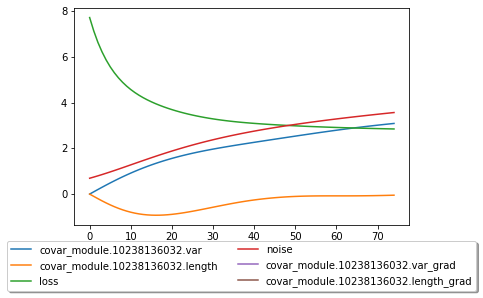

In [11]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [12]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([3.5853], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [13]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [14]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([3.5571], requires_grad=True))
('covar_module.10238136032.var', Parameter containing:
tensor(3.1079, requires_grad=True))
('covar_module.10238136032.length', Parameter containing:
tensor(-0.0433, requires_grad=True))


In [15]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 2.2374e+01,  0.0000e+00,  2.2293e+01,  ..., -2.2136e-02,
          3.6421e-03, -1.5885e-02],
        [ 0.0000e+00,  2.4397e+01,  1.9843e+00,  ..., -8.8926e-02,
          1.5885e-02, -6.5313e-02],
        [ 2.2293e+01,  1.9843e+00,  2.2374e+01,  ..., -3.0609e-02,
          5.1809e-03, -2.2136e-02],
        ...,
        [-2.2136e-02, -8.8926e-02, -3.0609e-02,  ...,  2.4397e+01,
          1.9843e+00,  2.4131e+01],
        [ 3.6421e-03,  1.5885e-02,  5.1809e-03,  ...,  1.9843e+00,
          2.2374e+01,  0.0000e+00],
        [-1.5885e-02, -6.5313e-02, -2.2136e-02,  ...,  2.4131e+01,
          0.0000e+00,  2.4397e+01]])
torch.return_types.eig(
eigenvalues=tensor([[ 7.3460e+02,  0.0000e+00],
        [ 6.4859e+02,  0.0000e+00],
        [ 4.2245e+02,  0.0000e+00],
        [ 2.8833e+02,  0.0000e+00],
        [ 1.5766e+02,  0.0000e+00],
        [ 6.3753e+01,  0.0000e+00],
        [ 1.8199e+01,  0.0000e+00],
        [ 4.0582e+00,  0.0000e+00],
        [ 7.4661e-01,  0.0000e+00],
        

Text(0.5, 1.0, 'Observed Values (Likelihood)')

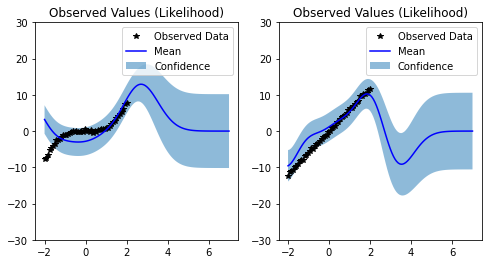

In [16]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [17]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [18]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [19]:
X = torch.linspace(float(-2), float(2), int(1))

In [20]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [40]:
print(SE)
print(SE.diff(x1))
print(SE.diff(x1).diff(x2))
print(SE.diff(x1).diff(x2).diff(x1))
print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> -sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^2
(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4
(x1, x2, l, sigma) |--> -3*sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^4 + sigma^2*(x1 - x2)^3*e^(-1/2*(x1 - x2)^2/l^2)/l^6
(x1, x2, l, sigma) |--> 3*sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4 - 6*sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^6 + sigma^2*(x1 - x2)^4*e^(-1/2*(x1 - x2)^2/l^2)/l^8


1.0

In [22]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

tensor([[0.3679]], grad_fn=<AddBackward0>)

In [23]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [24]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

[l_11 l_12 l_13]
[l_21 l_22 l_23]
[l_31 l_32 l_33]
[m_11 m_12 m_13]
[m_21 m_22 m_23]
[m_31 m_32 m_33]
[r_11 r_12 r_13]
[r_21 r_22 r_23]
[r_31 r_32 r_33]
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_11 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_21 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_31
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_12 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_22 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_32
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_13 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_23 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_33
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_11 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_21 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_31
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_12 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_22 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_32
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_13 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_23 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_33
(l_31*m_11 + l_32*m_21 + l_33*m_31)*r_11 + (l_31*m_12 + l_32*m_22 + l_33*m_32)*r_21 +

In [25]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [26]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


x-pos: 0 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 0 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---


[[1.0, 1.0], [1.0, 1.0]]

In [27]:
print(X)
print(torch.Tensor(cov_matr).eig())

tensor([-2.])
torch.return_types.eig(
eigenvalues=tensor([[2., 0.],
        [0., 0.]]),
eigenvectors=tensor([]))


In [28]:
exp(-(-2-0.66)^2/(2))

0.0290772266655467

In [29]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

List of all kernels: [Diff_SE_kernel(), Diff_SE_kernel()]
[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.9631, 0.0000],
        [0.1405, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)

In [30]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

tensor([[ 2.0000,  0.0000, -0.8120,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  2.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.8120,  0.0000,  2.0000, -0.4060,  0.0000,  1.0000],
        [ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000]])
tensor([[2., 1.],
        [1., 1.]])


tensor([[ 2.0000,  1.0000,  0.0000,  0.0000, -0.8120, -0.4060],
        [ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 0.0000,  0.0000,  2.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.8120, -0.4060,  0.0000,  0.0000,  2.0000,  1.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000]])

In [31]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [32]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

[[<__main__.testobject object at 0x2639c4f10>, <__main__.testobject object at 0x263a2a9a0>], [<__main__.testobject object at 0x263a2a9a0>, <__main__.testobject object at 0x2639c4e80>]]
170
170


In [33]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [34]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.3679, 0.0000],
        [0.3679, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)

In [35]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

[dx1, 2]

In [36]:
prod([1,2,3])

6

In [37]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

row: 0, col: 0
tensor(1.)
row: 0, col: 1
tensor(2.)
row: 0, col: 2
tensor(3.)
row: 1, col: 1
tensor(5.)
row: 1, col: 2
tensor(6.)
row: 2, col: 2
tensor(9.)


In [38]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

[a b]
[c d]
[dx1 dx1]
[  0 dx1]


[a*dx1 + c*dx1 b*dx1 + d*dx1]
[        c*dx1         d*dx1]

In [39]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


print(x is z)
z = x
print(x is z)


False
True
